# Fitting models and overfitting

Original Notebooks courtesy of Prof. Foster Provost and Rubing Li
***

In [ ]:
# Import the libraries we will be using

import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')


## Data: Predicting wine quality

_"All wines should be tasted; some should only be sipped, but with others, drink the whole bottle."_ - Paulo Coelho, Brida

We will use a data set related to the red variant of the Portuguese "Vinho Verde" wine. We will predict the "sensory" output based on physicochemical inputs.  (Here there is no data about grape types, wine brand, wine selling price, etc.). Our goal is to use machine learning to detect above-average wines (perhaps to send these wines later to professional tasters?).

Let's start by loading the data.

In [ ]:
# in this case, we can read the data direct from a URL, no download/upload required!

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_df = pd.read_csv(url, delimiter=";").dropna()
wine_df


In [ ]:
wine_df.describe().round(2)

# no missing values!!

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00
mean,8.32,0.53,0.27,2.54,0.09,15.87,46.47,1.00,3.31,0.66,10.42,5.64
std,1.74,0.18,0.19,1.41,0.05,10.46,32.90,0.00,0.15,0.17,1.07,0.81
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40,3.00
25%,7.10,0.39,0.09,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50,5.00
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,1.00,3.31,0.62,10.20,6.00
75%,9.20,0.64,0.42,2.60,0.09,21.00,62.00,1.00,3.40,0.73,11.10,6.00
max,15.90,1.58,1.00,15.50,0.61,72.00,289.00,1.00,4.01,2.00,14.90,8.00


Now, let's turn this into a classification problem -  our goal is to identify above-average wines, not accurately predict the quality score.  We create a binary "is_good" attribute if the quality is greater than the mean (aka `quality >= 6`)

In [ ]:
avg_quality = wine_df.quality.mean()
wine_df["is_good"] = wine_df.quality > avg_quality
wine_df.is_good.value_counts()


In [ ]:
# lets do some data cleanup

# we can remove the original feature, quality

wine_df = wine_df.drop("quality", axis="columns")

# Lets make column names easier to work with - replace white spaces with underscores

wine_df.columns = [c.replace(' ', '_') for c in wine_df.columns]
wine_df.head(5)

In [ ]:
# Now let's set ourselves up for predictive modeling
# Identify the predictor (X) columns
column_names = wine_df.columns
predictor_columns = column_names[:-1] # this removes the last column

Let's explore whether any of the features seem to be very predictive by themselves.

In [ ]:
rows = 4
cols = 3
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(5*cols, 6*rows))
axs = axs.flatten()
for i in range(len(predictor_columns)):
    sns.boxplot(x='is_good', y=predictor_columns[i], data=wine_df, ax=axs[i],
                hue='is_good',legend=False)
plt.tight_layout()

There's no single feature that can separate the data perfectly. Alcohol and total sulfur dioxide look somewhat predictive though.

Lets pick a few of the features that look important and plot a pairwise scatterplot matrix.

In [ ]:
# plot a scatterplot matrix of all of the features
# use a sample of 250 for simplicity

features = ["alcohol", "sulphates","total_sulfur_dioxide","volatile_acidity","is_good"]
sns.pairplot(wine_df[features].sample(250), hue='is_good', palette=['red','blue'], plot_kws={'s': 10})


## Fitting a Decision Tree
Let's now fit a model using a tree.  And in particular, classification trees, since our target is to predict (the probability of) whether the wine is good or not -- binary classification (class probability estimation).

Lets fit a simple - depth = 4 - tree to see which features seem to be most important

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score



X = wine_df[predictor_columns]
Y = wine_df.is_good

# split data into train and test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

model = DecisionTreeClassifier(max_depth=4, criterion="entropy")
model.fit(X_train,Y_train)
plt.figure(figsize=(25,20))
plot_tree(model, feature_names=X.columns, filled=True, class_names=["Good=No", "Good=Yes"], impurity=False, rounded=True)
plt.show()



Lets compare our accuracy metric applied to our Training Data compared to our Test Data.

Which do you think will be better?

In [ ]:
# calculate accuracy of the tree as applied to the training data
train_acc = accuracy_score(model.predict(X_train), Y_train)
test_acc = accuracy_score(model.predict(X_test), Y_test)
print ("Training Accuracy = %.4f" % train_acc)
print ("Test Accuracy = %.4f" % test_acc)

Training Accuracy = 0.7647
Test Accuracy = 0.6875


We can extract probabilities from our test set using `predict_proba`.  Lets see what the distribution of probabilities is

In [ ]:
y_probs = model.predict_proba(X_test)[:, 1]

# Plot the probabilities as a histogram
plt.hist(y_probs, bins=20)
plt.xlabel("Probability of Wine Being Good")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.show()

## Complexity Control using `max_depth`

In a prior notebook, we found the best depth of the tree by cycling over max_depth.  Here we will do this again - and plot the complexity vs performance curve.

In [ ]:
depths_list = np.arange(1,31,2)
train_accs = []
test_accs = []


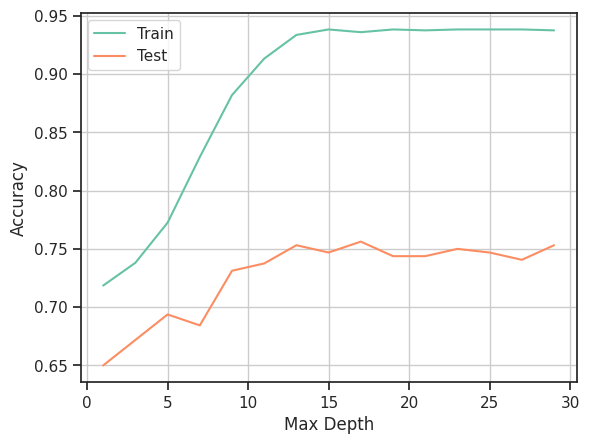

In [ ]:
for depth in depths_list:
  model = DecisionTreeClassifier(max_depth=depth,criterion="entropy",min_samples_leaf=4)
  model.fit(X_train,Y_train)
  train_accs.append(accuracy_score(model.predict(X_train), Y_train))
  test_accs.append(accuracy_score(model.predict(X_test), Y_test))


# plot train_accs and test_accs on same plot as different lines
plt.plot(depths_list, train_accs, label="Train")
plt.plot(depths_list, test_accs, label="Test")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

Hmm - the test performance data does not decrease as we expect it to in this case.  That happens sometimes!  Particularly in cases with small data sets, or when the patterns are not very complicated.  

 In this case, choose a value of the parameter at the point that it "levels off".  Use _Occam's Razor_ : pick the simplest model that has good accuracy.  

## Cross validation

Above, we made a single train/test split. We set aside 20% of our data and *never* used it for training. We also never used the 80% of the data set aside for training to test generalizability.  Note that there are two potential problems with the simple holdout approach.

1) Perhaps the random split was particularly bad (or good).  Do we have any confidence in our accuracy estimate?

2) We are using only 20% of the data for testing.  Could we possibly use the data more fully for testing?

3) Often we want to know something about the distribution of our evaluation metrics. A simple train/test split only allows a single "point estimate"

Instead of only making the split once, let's use **cross-validation** -- every record will contribute to testing as well as to training.


<img src="https://github.com/pearl-yu/foster_2022fall/blob/2022-master/Module3_Fitting_CrossVal/images/cross.png?raw=1" alt="Drawing" style="width: 60px;"/>

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

kf=KFold(n_splits=5, shuffle=True, random_state=12)
cv_accs = []

for depth in depths_list:
  model = DecisionTreeClassifier(max_depth=depth,criterion="entropy")
  scores = cross_val_score(model, X, Y, scoring="accuracy",cv=kf)
  cv_accs.append(scores.mean())


plt.plot(depths_list, cv_accs)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid()




#print ("Cross Validated Accuracy: %0.3f +/- %0.3f" % (scores.mean(), scores.std()))

In [ ]:
# plot train_accs and test_accs on same plot as different lines
plt.plot(depths_list, train_accs, label="Train")
plt.plot(depths_list, test_accs, label="Test")
plt.plot(depths_list, cv_accs, label="CV")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

Can also try Leave One Out Cross-Validation.

This will get a better estimate but will take a lot more time!!!

Lets just do one iteratino since it takes about a minute for each one..

In [ ]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
loo=LeaveOneOut()


model = DecisionTreeClassifier(max_depth=10,min_samples_split=5,criterion='entropy')
scores = cross_val_score(model, X, Y, scoring="accuracy", cv=loo)

print ("Cross Validated Accuracy: %0.3f +/- %0.3f" % (scores.mean(), scores.std()))

Cross Validated Accuracy: 0.745 +/- 0.436


# Apply to HW1 Data (HudsonU)

Lets do the same comparison for our HW1 data, using as our target whether the chance of admission was greater than 0.5.

In [ ]:

from google.colab import files
uploaded = files.upload()

Saving HudsonU.csv to HudsonU.csv


In [ ]:
admissions=pd.read_csv("HudsonU.csv")
admissions=admissions.rename(columns={"Serial No.": "ID", "GRE Score": "GRE","TOEFL Score":"TOEFL","University Rating":"Rating","Chance of Admit":"Admit"})

admissions.head()


In [ ]:
X = admissions[['GRE', 'TOEFL', 'Rating', 'SOP', 'LOR', 'CGPA', 'Research']]
y = admissions['Admit']> 0.5

# split into test set and training set using 20% for test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Load data on predicting Chance of admit

cv_accs = []
train_accs = []
test_accs = []
kf=KFold(n_splits=5, shuffle=True, random_state=123)
depths_list = np.arange(1,31,2)

for depth in depths_list:
  model = DecisionTreeClassifier(max_depth=depth,criterion="entropy")
  model.fit(X_train,y_train)
  train_accs.append(accuracy_score(model.predict(X_train), y_train))
  test_accs.append(accuracy_score(model.predict(X_test), y_test))
  scores = cross_val_score(model, X, y, scoring="accuracy",cv=kf)
  cv_accs.append(scores.mean())

plt.plot(depths_list, train_accs, label="Train")
plt.plot(depths_list, test_accs, label="Test")
plt.plot(depths_list, cv_accs, label="CV")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()



